<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> Bayesian Vector Autoregressive Models </font></h3>   
   
    以下のコードは以下から引用しました。
    https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html
    
    License notice
    All the notebooks in this example gallery are provided under the MIT License (https://github.com/pymc-devs/pymc-examples/blob/main/LICENSE) which allows modification, and redistribution for any use provided the copyright     and license notices are preserved.

In [1]:
!pip install pymc

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.4/472.4 kB 9.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 44.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9097 sha256=43fe7655ff9aa8a4328d36d420dbe37ace2df79f66c5012803cd5287f33a8c2e
  Stored in directory: /root/.cache/pip/wheels/a4/11/f5/8265470e17d280d8b5910e1b0f298521420a5086d696e96799
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13912 sha256=1cd11159e4e96a6b1ca1e91a50fe8e06f71625beeacd881d68e392ca1039a926
  Stored in directory: /root/.cache/pip/wheels/ba/95/1f/29d557452d7f5102769deb2bdc

In [2]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm

from pymc.sampling_jax import sample_blackjax_nuts

In [3]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
def simulate_var(
    intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, 
    noise=(1, 1), *, warmup=100, steps=200):
    
    draws_y = np.zeros(warmup + steps)
    draws_x = np.zeros(warmup + steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup + steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step - 1]
            + coefs_yy[1] * draws_y[step - 2]
            + coefs_xy[0] * draws_x[step - 1]
            + coefs_xy[1] * draws_x[step - 2]
            + rng.normal(0, noise[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step - 1]
            + coefs_xx[1] * draws_x[step - 2]
            + coefs_yx[0] * draws_y[step - 1]
            + coefs_yx[1] * draws_y[step - 2]
            + rng.normal(0, noise[0])
        )
    return draws_y[warmup:], draws_x[warmup:]

In [5]:
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

df = pd.DataFrame({"x": var_x, "y": var_y})
df.head()

,x,y
0,34.606613,30.117581
1,34.773803,23.996700
2,35.455237,29.738941
3,33.886706,27.193417
4,31.837465,26.704728


Text(0.5, 1.0, 'Series Y')

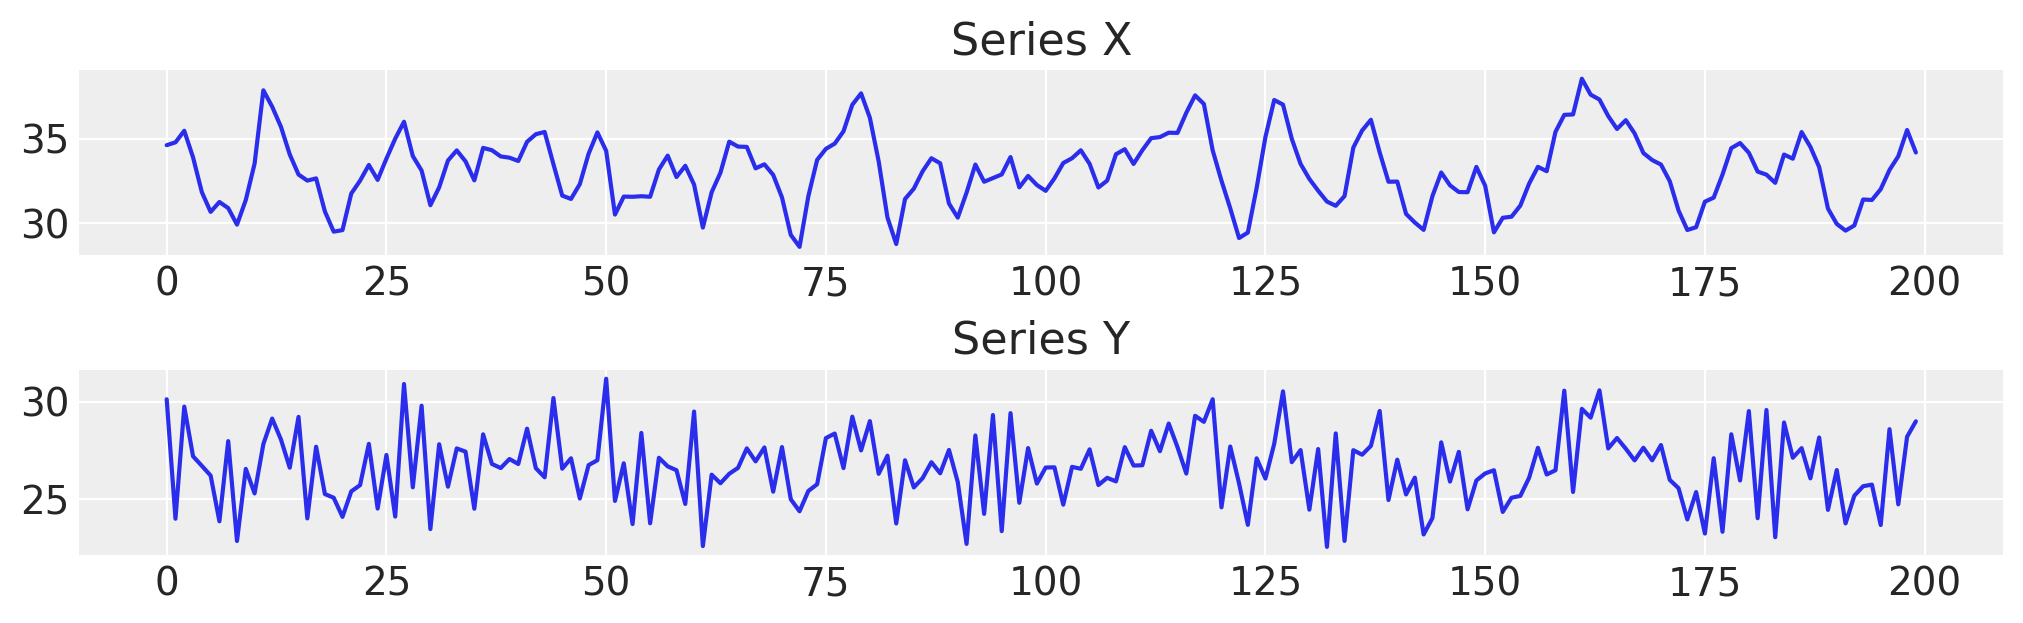

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 3))
axs[0].plot(df["x"], label="x")
axs[0].set_title("Series X")
axs[1].plot(df["y"], label="y")
axs[1].set_title("Series Y")

In [9]:
# 各ラグ項の各時系列方程式における、
# 周辺寄与の自己回帰ステップを構築するヘルパー関数を定義します。

def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pm.math.sum(
            [
                pm.math.sum(lag_coefs[j, i]* df.values[n_lags - (i + 1): -(i + 1)], axis=1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        ars.append(ar)
    beta = pm.math.stack(ars, axis=-1)
    
    return beta

# モデルを構築する際に、異なる尤度項の仕様に対応でき、
# 単純な事前予測チェックが実行できるようにします。
# この後者の機能は、形状の処理に関するデバッグに重要です。
# VARモデルの構築にはかなり多くの動作部分があり、
# 事前予測チェックで示される形状を検査することが便利です。

def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.range(n_lags) + 1,
        "equations": df.colums.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }
    
    with pm.Model(coords=coords) as model:
        lag_coefs = pm.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pm.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        data_obs = pm.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)
        
        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pm.Deterministic(
            "betaX",
            betaX,
            dims=[
                "time",
            ],
        )
        mean = alpha + betaX
        
        if mv_norm:
            n = df.shape[1]
            # 内部では、LKJ事前分布は相関行列も保持します。
            noise_chol, _, _ = pm.LKJcholeskyCov(
               "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pm.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
        else:
            # これは係数の適切な推定を回復できる代替尤度ですが、
            # 時系列間の多変量相関が欠けています。
            sigma = pm.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pm.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dim=["time", "equations"]
            )
            
        if prior_checks:
            idata = pm.sample_prior_predictive()
            return model, idata
        else:
            idata = pm.sample_prior_predictive()
            idata.extend(pm.sample(draws=2000, random_seed=130))
            pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
    return model, idata